In [2]:
pip install pystan==2.19.1.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install prophet

     |████████████████████████████████| 65 kB 581 kB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 1.2 MB/s eta 0:00:01
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6643429 sha256=61dde38cea4da1839f58cfede7fe4becbe8ebdff27397aea3f685f95865e10e9
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prophet import Prophet

In [12]:
df = pd.read_csv('/kaggle/input/reduced-data/reduced_dataset.csv')

In [13]:
display(df)

,State Code,County Code,Site Num,Address,State,County,City,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,...,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,date
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,19.041667,49.0,19,...,34,3.000000,9.0,21,13.0,1.145833,4.200,21,NaN,2000-01-01
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,19.041667,49.0,19,...,34,3.000000,9.0,21,13.0,0.878947,2.200,23,25.0,2000-01-01
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,19.041667,49.0,19,...,34,2.975000,6.6,23,NaN,1.145833,4.200,21,NaN,2000-01-01
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,19.041667,49.0,19,...,34,2.975000,6.6,23,NaN,0.878947,2.200,23,25.0,2000-01-01
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,22.958333,36.0,19,...,27,1.958333,3.0,22,4.0,0.850000,1.600,23,NaN,2000-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741624,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,1.083333,1.6,9,...,44,0.000000,0.0,2,NaN,0.091667,0.100,2,1.0,2016-03-30
1741625,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.939130,1.3,5,...,44,-0.022727,0.0,0,0.0,0.067714,0.127,0,NaN,2016-03-31
1741626,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.939130,1.3,5,...,44,-0.022727,0.0,0,0.0,0.100000,0.100,0,1.0,2016-03-31
1741627,56,21,100,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.939130,1.3,5,...,44,0.000000,0.0,5,NaN,0.067714,0.127,0,NaN,2016-03-31


In [14]:
# compute mean AQI for each citiy for each date
mean_aqi = df.groupby(['City','date'])[['NO2 AQI','O3 AQI','SO2 AQI','CO AQI']].mean()

# check new data frame
mean_aqi.head(3)

NO2 AQI  O3 AQI  SO2 AQI  CO AQI
City        date                                        
Albuquerque 2011-01-01     19.0    30.0      0.0     2.0
            2011-01-02     38.0    28.0      1.0     7.0
            2011-01-03     44.0    14.0      3.0    13.0

In [15]:
# check data shape
mean_aqi.shape

(359263, 4)

In [16]:
# check descriptive statistics
mean_aqi.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
count,359263.000000,359263.000000,359263.000000,359089.000000
mean,24.235140,36.149585,7.512030,6.100780
std,14.913906,19.902530,12.302273,5.957218
min,0.000000,0.000000,0.000000,0.000000
25%,13.000000,25.000000,1.000000,2.000000
50%,23.000000,33.000000,3.000000,5.000000
75%,33.500000,42.000000,9.000000,8.000000
max,132.000000,218.000000,200.000000,201.000000


In [17]:
# check na counts
mean_aqi.isna().sum()

NO2 AQI      0
O3 AQI       0
SO2 AQI      0
CO AQI     174
dtype: int64

In [18]:
# reset index mean_aqi 
mean_aqi = mean_aqi.reset_index()

In [19]:
# select one single city for analysis and for developing proof of concepts
city = 'Washington'

# select one column for analysis and for developing proof of concepts
col = 'O3 AQI'

In [78]:
# create subset of dataset to include only city and column selected for analysis
new_df = mean_aqi.loc[mean_aqi['City'] == city,['date',col]]

# check data
new_df.head(3)

,date,O3 AQI
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0


In [79]:
new_df = new_df.rename(columns = {"date": "ds",
                        "O3 AQI": "y"})
display(new_df)

,ds,y
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0
335186,2000-01-04,20.0
335187,2000-01-05,21.0
...,...,...
340969,2016-04-26,51.0
340970,2016-04-27,29.0
340971,2016-04-28,27.0
340972,2016-04-29,23.0


In [80]:
# ts shape
new_df.shape

(5791, 2)

In [81]:
# resample time series to Daily Frequency
# resample ensures that all dates from begining to end of the start series are present
# use ffill  forward fill to handle missing valye filling the missing value from the previous day
new_df = new_df.ffill()
new_df.head(3)

,ds,y
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0


In [82]:
# ts shape after resampling
ts.shape

(5791, 2)

In [83]:
display(new_df)

,ds,y
335183,2000-01-01,12.0
335184,2000-01-02,25.0
335185,2000-01-03,22.0
335186,2000-01-04,20.0
335187,2000-01-05,21.0
...,...,...
340969,2016-04-26,51.0
340970,2016-04-27,29.0
340971,2016-04-28,27.0
340972,2016-04-29,23.0


<AxesSubplot:xlabel='ds'>

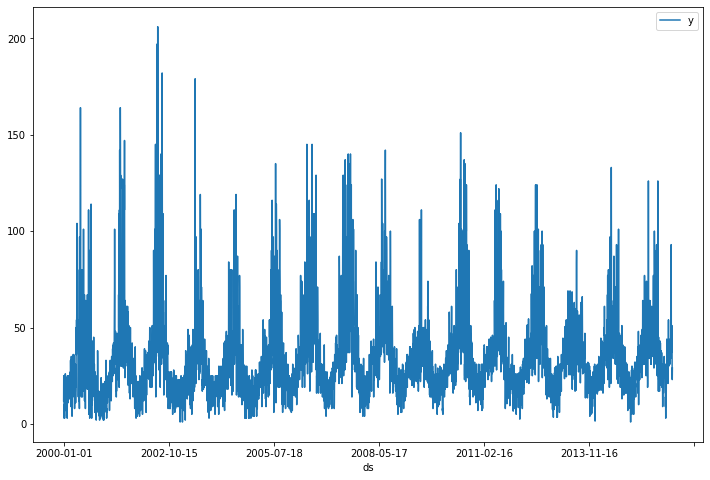

In [90]:
# visualize dataframe
new_df.plot(x ='ds', y='y', kind = 'line', figsize=(12,8))


In [91]:
prophet_model = Prophet()
prophet_model.fit(new_df)

In [92]:
# the parameter 'periods' represents the number of days you want to predict
future = prophet_model.make_future_dataframe(periods=2000)
future.tail()

,ds
7786,2021-10-17
7787,2021-10-18
7788,2021-10-19
7789,2021-10-20
7790,2021-10-21


In [93]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7786,2021-10-17,26.843872,1.092219,54.381626
7787,2021-10-18,25.439220,0.404226,52.971536
7788,2021-10-19,26.582017,0.524803,53.918028
7789,2021-10-20,25.682555,0.714833,54.490875
7790,2021-10-21,26.096047,0.814306,51.264389


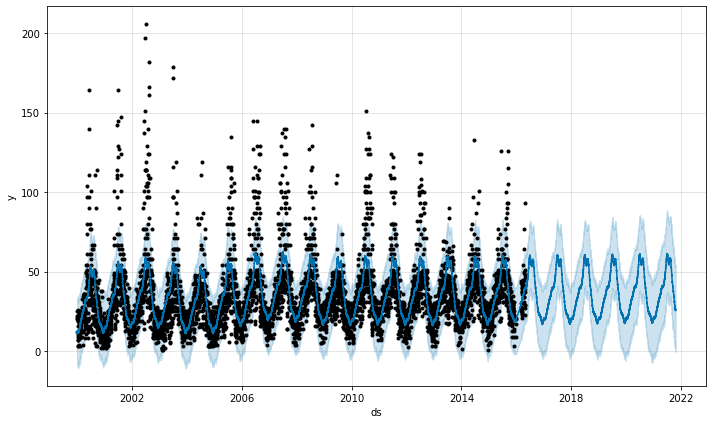

In [94]:
output = prophet_model.plot(forecast)